# Use Case Sport Image Classification

**Introduction:**

Welcome to HES-Xplain, our interactive platform designed to facilitate explainable artificial intelligence (XAI) techniques. In this use case, we dive into sport image classification and showcase the utility of eXplainable AI (XAI) in this domain. We will focus on applying tools available on our platform to interpret and understand the decisions made by a Convolutional Neural Network (CNN) model.

We also provide scripts, conveniently customizable, facilitate data loading, model training and evaluation, and performance metric plotting. Located in the scripts folder of this repository, they feature clear annotations to aid comprehension and instructions for effortless adaptation to your specific model needs.

We will go through some state of the art XAI techniques, such as SHAP value, Lime or Class Activation Maps (CAM), and some tools that wer designed by our team such as RulesExtraction. To do this we will use a pre-trained model, a dataset of sport images, and HES-Xplain to interpret the model's predictions. By the end of this use case, you'll have a solid understanding of CAM and how to integrate it into your own image classification projects.

**Objectives:**

1. Understand the importance of interpretability in image classification.
2. Introduce XAI techniques to interpret classification and understand a CNN model.
3. Showcase the capabilities of HES-XPLAIN. 
4. Provide practical insights into applying such techniques through an interactive notebook.
5. Foster a community of XAI enthusiasts and practitioners.

**Outline:**

1. Dataset and Problem Statement.
2. Model Architecture.
3. Modeling, training, and evaluation.




## Google Colab Setup

This section prepares the notebook for use with Google Colaboratory. If applicable, change the following variable to **True**:


In [5]:
# Colab compatibility
use_colab = False

Prepare the code by downloading the code and installing required packages.

In [6]:
if use_colab:
    # ensure the directory is empty
    !rm -rf * .config

    !# install codebase from GitHub
    !git clone --no-checkout https://github.com/HES-XPLAIN/notebooks.git --depth=1 .
    !git config core.sparseCheckout true
    !git sparse-checkout set --cone
    !git sparse-checkout add use_case_sport_classification
    !git sparse-checkout reapply
    !git checkout main

    # adjust folder structure
    !mv use_case_sport_classification/* .
    !rm -rf use_case_sport_classification/

In [7]:
if use_colab:
    # Install dependencies
    !pip install omnixai

When asked to, restart the session by clicking on the **"Restart Session"** button, then continue and execute the next cells.


In [8]:
# Apply workaround for checksum issue with EfficientNet, see https://github.com/pytorch/vision/issues/7744
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict
    
efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

KeyError: 'check_hash'

## Workspace Setup

This section download the required code and models from our GitHub and huggingface.co repositories.


Download the dataset and models.


In [9]:
# download and extract dataset
import zipfile
from huggingface_hub import hf_hub_download

REPO_ID = "HES-XPLAIN/SportsImageClassification"
FILENAME = "SportsImageClassification.zip"
dataset_file_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, repo_type="dataset")
extract_path = 'data'

# Unzip the file
with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset successfully extracted to: {extract_path}")

Dataset successfully extracted to: data


In [10]:
!mkdir -p models_weight
!curl -OL https://huggingface.co/HES-XPLAIN/sport_classification/resolve/main/FineTunedEfficientNet_30epochs.pth -o FineTunedEfficientNet_30epochs.pth
!curl -OL https://huggingface.co/HES-XPLAIN/sport_classification/resolve/main/VGGFineTuned.pth -o VGGFineTuned.pth
!mv *.pth models_weight/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1166  100  1166    0     0   8269      0 --:--:-- --:--:-- --:--:--  8269
100 21.2M  100 21.2M    0     0  37.3M      0 --:--:-- --:--:-- --:--:-- 85.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1138  100  1138    0     0   8246      0 --:--:-- --:--:-- --:--:--  8246
100  516M  100  516M    0     0   106M      0  0:00:04  0:00:04 --:--:--  111M


---

## Dataset and Problem Statement


The sport image classification dataset used in this use case consists of approximately 15,000 images, covering 100 different sports categories. This dataset, available on [Kaggle](https://www.kaggle.com/datasets/gpiosenka/sports-classification), contains a total of 13,493 train images, 500 test images, and 500 validation images. The images are in JPG format and have dimensions of 224x224 pixels with 3 color channels.

**Problem Statement:** Our objective is to build a robust image classifier capable of accurately classifying sport images among the 100 predefined sports categories. The nature of the dataset, comprising images of various sports, makes it particularly suitable for introducing and visualizing XAI techniques. By leveraging deep learning techniques and Class Activation Maps (CAM), we aim to not only achieve high classification performance but also gain insights into the discriminative regions within the images that contribute to the classification decisions.

In [11]:
# global imports
import os
import torch
import json
import pandas as pd
import numpy as np
import torch.nn as nn

from PIL import Image
from scripts.custom_dataset import CustomDataset
from scripts.models import FineTunedEfficientNet
from scripts.helpers import *
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [90]:
# set global variables
home_path = "./"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with open(os.path.join(home_path, 'data/idx_to_names.json'), 'r') as file:
    class_dict = json.load(file)
class_labels = list(class_dict.values())
with open('./data/idx_to_names.json', 'r') as file:
    idx_to_names = json.load(file)
class_labels = list(idx_to_names.values())
names_to_idx = {v: k for k, v in idx_to_names.items()}

# Assuming class_dict is your dictionary with string keys
class_dict_int_keys = {int(key): value for key, value in class_dict.items()}

# get the data loaders
train_loader, _, test_loader = get_dataloaders()

### Load the Model

In this use case, we leverage the power of transfer learning and fine-tuning by utilizing a pre-trained model. Specifically, we will be using a fine-tuned EfficientNet and a VGG model that have already learned valuable features from a large-scale dataset. To perform inference with this model, we will need to include the class definition script.

**Class Definition Script:**

You can find the class definition script (`class.py`) in the `scripts` directory of this notebook that define a VGG and an efficientnet model. You can create a similar class with the model of your needs,  just make sure to adapt it to the number of classes of your dataset, here it is 100 classes. 

The script contains the necessary custom class definitions and functions required for the sport image classification task. Make sure to include and import this script in your code to ensure proper model instantiation and inference.

To load the fine-tuned weights into the model, you can use the following code snippet:

```python
import torch
from scripts.class import YourCustomModelClass

# Create an instance of your PyTorch model
model = YourCustomModelClass()

# Load the fine-tuned weights into the model
model.load_state_dict(torch.load("path_to_your_fine_tuned_weights.pth"))

# Set the model to evaluation mode
model.eval()

# Perform inference using the model
# ...

In [13]:
from scripts.models import FineTunedVGG

model = FineTunedVGG(num_classes=100)

checkpoint = torch.load(os.path.join(home_path, "models_weight/VGGSportsImageClassification.pth"), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print("Model state loaded :)")

Model state loaded :)


### Model Architecture

For now, we will utilize the VGG16 architecture, which has demonstrated excellent performance in image classification tasks. VGG16 models are known for their simplicity and effectiveness, making them widely used in various computer vision applications.

VGG16 consists of several convolutional layers followed by fully connected layers. The architecture is characterized by its deep stack of convolutional layers, which allows it to learn complex features from input images.

In our case, we will use the VGG16 model with the following specifications:

- Model: VGG16
- Pretrained: Yes
- Number of classes: 100

VGG16 is a well-established model in the computer vision community and has been pretrained on large-scale image datasets like ImageNet. By leveraging transfer learning and fine-tuning, we can utilize the pre-trained weights of VGG16 to enhance our model's performance on the sport image classification task.

In [14]:
model

FineTunedVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

### Training 

As previously described, we've loaded a pretrained model that underwent fine-tuning. However, if desired, you have the option to further fine-tune it using either our train scripts or the train functions provided, both defined in ./scripts/train.py. To save on computation time, we've omitted the fine-tuning process here, but you can simply uncomment the next cell to observe its functionality.

In [15]:
# using the script 
#!python scripts/train.py --epochs 50 --lr 0.0001 --model vgg --name CustomName

# or using the function 
# from scripts.train import train
# and use it as you needs

### Evaluation and performance metrics

In order to evaluate our model performance let's have a look at some metrics, confusion matrix and training curves.
These scripts are define in the scripts folders, once again you can use them and easily adapt them to your needs. 


In [16]:
from scripts.evaluate import evaluate

accuracy, f1, cm = evaluate(model, test_loader)

The device is: cuda


  0%|          | 0/32 [00:00<?, ?it/s]

Test accuracy: 97.20%
Test F1 score: 94.75%


The test set exhibits excellent accuracy and F1 score. Fine-tuning an EfficientNet model enables us to achieve high performance without dedicating excessive time to training. Although the confusion matrix reveals a few instances that were misclassified, the overall performance remains highly satisfactory.


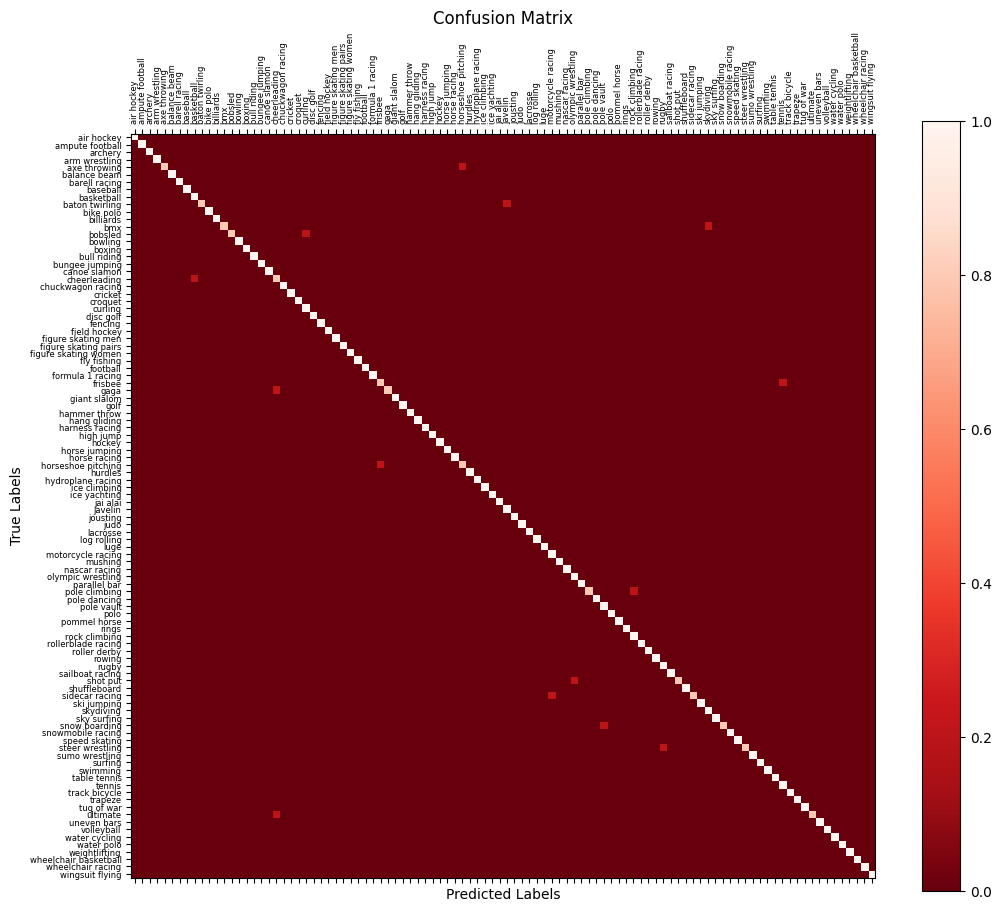

In [6]:
plot_confusion_matrix(cm, class_labels = class_labels)

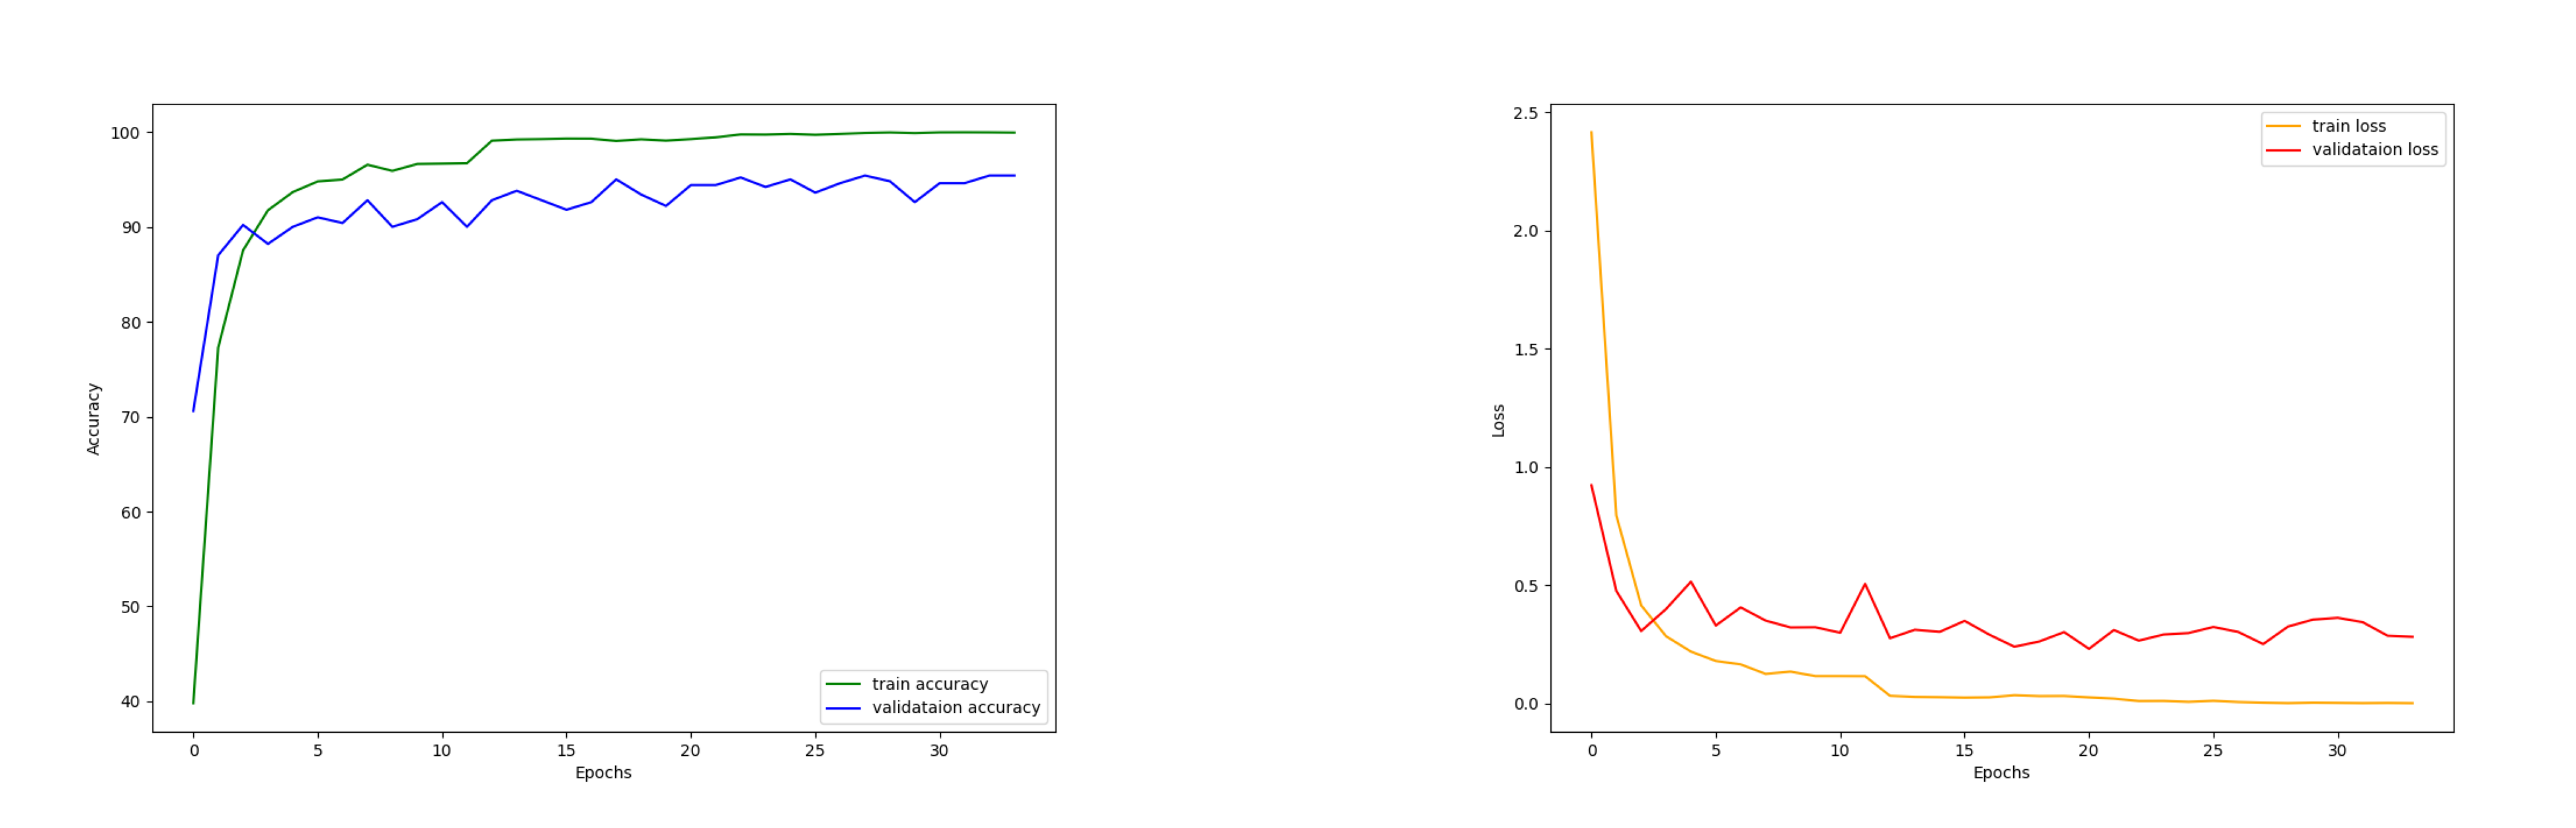

In [7]:
accuracy_plot = Image.open(os.path.join(home_path, "./plots/VGGSportsImageClassification_accuracy_plot.png"))
loss_plot = Image.open(os.path.join(home_path, "./plots/VGGSportsImageClassification_loss_plot.png"))

fig, axs = plt.subplots(1, 2, figsize=(50, 25))

axs[0].imshow(accuracy_plot)
axs[0].axis('off')

axs[1].imshow(loss_plot)
axs[1].axis('off')

plt.show()

As anticipated, the learning curves demonstrate favorable outcomes, with a minimal disparity observed between the training and validation sets for both accuracy and loss. This slight difference suggests a minor degree of overfitting. Nonetheless, the model's impressive performance on the test set affirms its ability to effectively generalize and make accurate predictions.

## Class Activation Mapping

Now, we aim to gain insights into our model's predictions and understand its feature importance, contributing to its high prediction capability. One potent technique for this purpose is Class Activation Mapping (CAM). CAM methods enable the identification of regions crucial for model predictions. Among these, grad-CAM and similar methods stand out, leveraging gradient computation with respect to the feature map to pinpoint significant regions. For more in-depth exploration, you can explore our CAM demo available on HES-XPLAIN platform. Within our platform, multiple CAM methods are accessible through omniXAI. In this context, we'll demonstrate how to apply them to our sports image use cases.

In [17]:
# import CAM implementation from omniXAI package

from omnixai.data.image import Image as omniImage
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM, LayerCAM, GradCAMPlus
from omnixai.explainers.vision.specific.scorecam.pytorch.scorecam import ScoreCAM

### Model Validation using CAM

In [56]:
import os
from PIL import Image
import numpy as np

# Load your images with PIL and stack them with numpy
img1 = np.array(Image.open(os.path.join(home_path, "data/test/giant slalom//2.jpg")).convert('RGB'))
img2 = np.array(Image.open(os.path.join(home_path, "data/test/volleyball//2.jpg")).convert('RGB'))
img3 = np.array(Image.open(os.path.join(home_path, "data/test/ampute football//5.jpg")).convert('RGB'))
img4 = np.array(Image.open(os.path.join(home_path, "data/test/nascar racing/3.jpg")).convert('RGB'))
batch_of_images = np.stack([img1, img2, img3, img4], axis=0)

# load them in the omniXAI images data type
images = omniImage(batch_of_images, batched=True)


[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

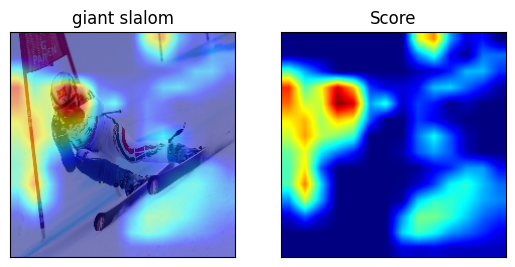

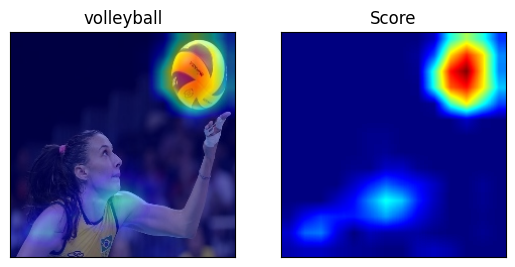

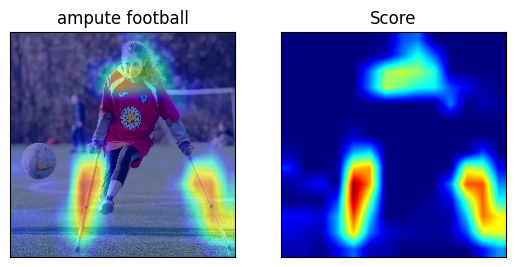

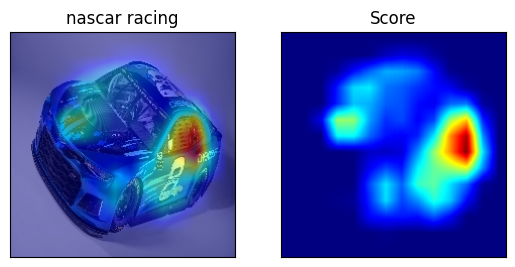

In [57]:
preprocess = lambda ims: torch.stack([test_transform()(im.to_pil()) for im in ims])

gradcam = GradCAM(
    model=model,
    target_layer=model.features[-2],
    preprocess_function=preprocess
)
# Explain the top label
explanations = gradcam.explain(images)
explanations.plot(class_names=class_dict_int_keys)

### Identifying a bias with CAM 

Even though a model may achieve a very high score, it does not guarantee its ability to generalize well to real-world data. High-level feature detection using CAM methods can help confirm this, or as we'll see, detect biases. Let's consider the example of an axe throwing class. You might expect a perfect model to use the presence of the axe to identify this sport. However, Grad-CAM reveals that the model relies solely on the presence of the target. Now, what if we use an image of axe throwing without the target? It's likely that the model will fail.

Once again more details of this example are given in the CAM demo notebook, check it!

In [78]:
axe3 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/3.jpg")).convert('RGB'))
axe4 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/4.jpg")).convert('RGB'))

# another way to load a batch of images to the omniImage datatype
axes = omniImage(data=np.concatenate([axe3.to_numpy(), axe4.to_numpy()]), batched=True)

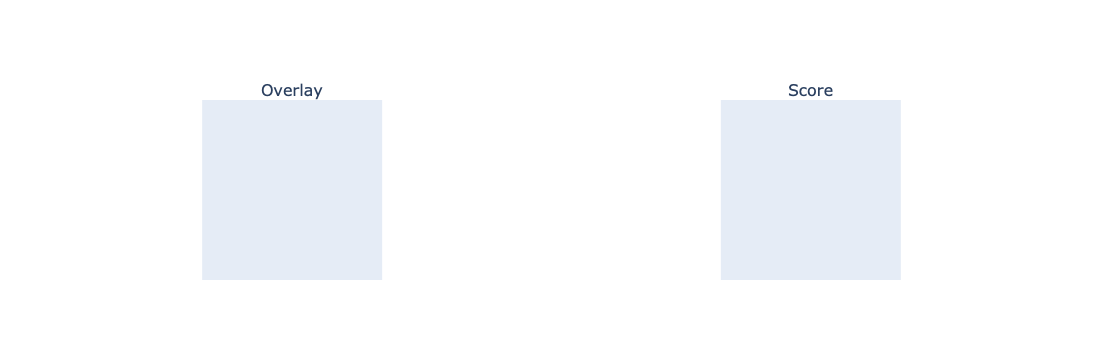

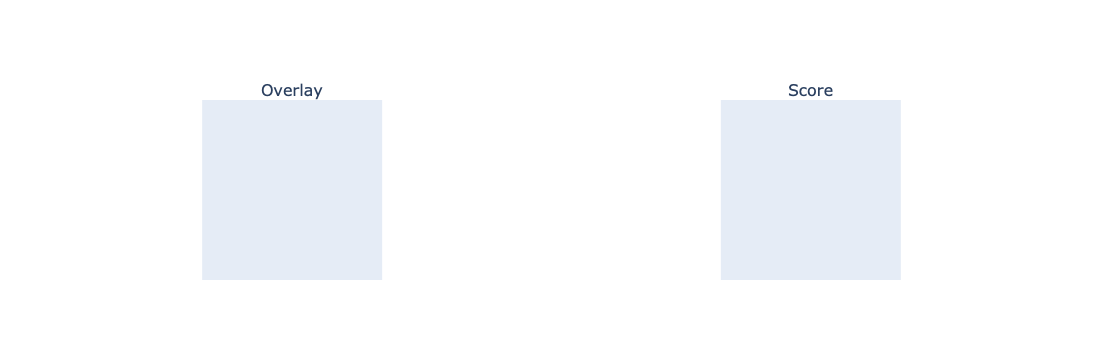

In [79]:
explanations = gradcam.explain(axes)
# another way to plot an explanation of type PixelImportance
for i in range(len(axes)):
    explanations.ipython_plot(index=i, class_names=class_dict_int_keys)

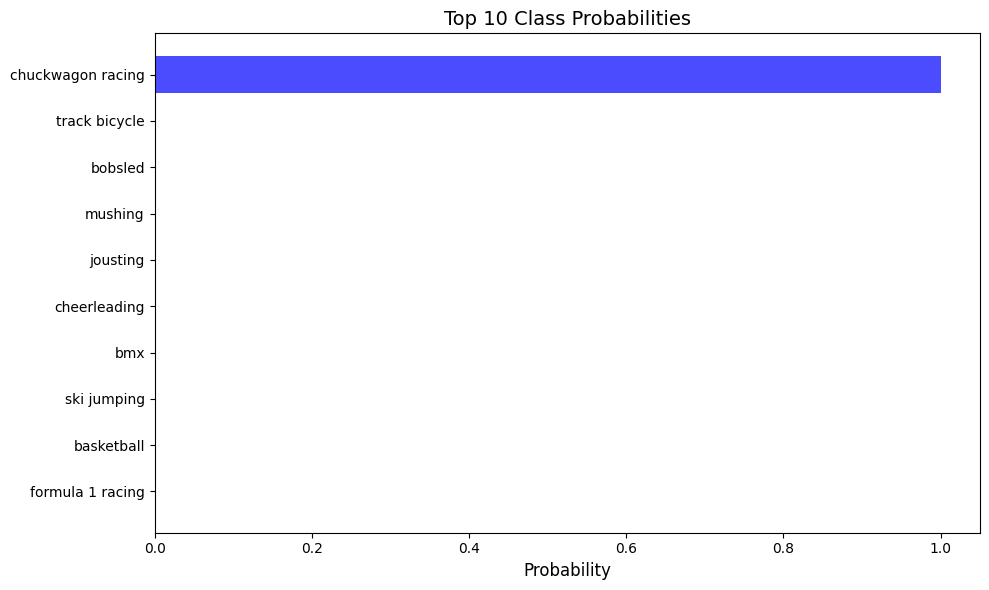

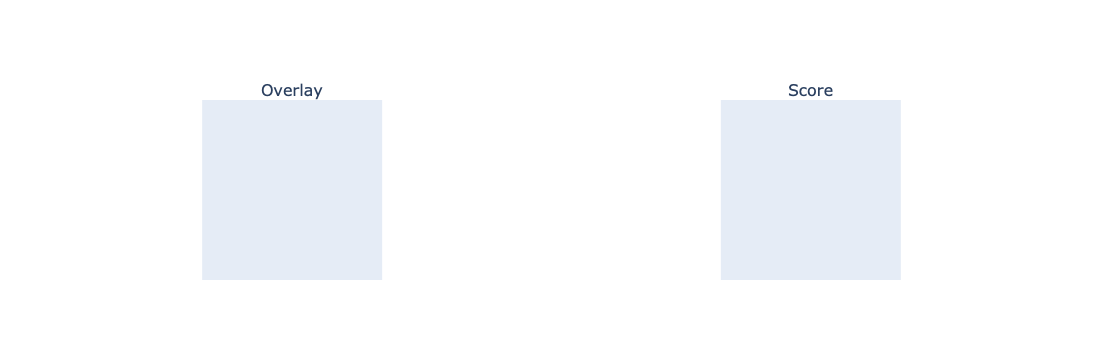

In [77]:
# let's see with an axe image without a target

new_axe = omniImage(Image.open(os.path.join(home_path, "data/hache.jpg")).convert('RGB'))
explanations = gradcam.explain(new_axe)
plot_prediction(model, os.path.join(home_path, "data/hache.jpg"), test_transform(), class_dict)
explanations.ipython_plot(index=0, class_names=class_labels)

As anticipated, the model fails to predict axe throwing for this particular challenging image. One of the main reasons for this is the absence of similar images in the training dataset. While a human observer could infer the class of the image based on the presence of three axes, our model lacks the exposure to labeled images of axe throwing without a target. Consequently, it fails to establish a connection between the concept of axes and the sport of axe throwing.

Solution :

One potential solution is to augment the dataset by adding new images and then retrain the model. By incorporating a more diverse set of images, we can provide the model with additional examples of axe throwing without a target, enabling it to learn the association between axes and the sport more effectively. After this retraining process, we can utilize XAI and Class Activation Maps (CAM) to examine whether the model has successfully overcome the bias present in the original dataset.

This bias, resulting from the limited representation of axe throwing without a target, is known as dataset bias. Through XAI techniques such as CAM, we can gain insights into how the model's attention is focused and determine whether it has acquired the ability to accurately identify and classify axe throwing instances, even in the absence of a visible target.

## Rules Extraction

Now we will go through our python library [Rules Extraction](https://github.com/HES-XPLAIN/rules-extraction) and see how can use it to have a better understanding of our model and also simply our over complex CNN model to a simple set of rules that were computed from the last convolutional map of the CNN model. 

Specifically, we aim to simplify our overly complex CNN model into a concise set of rules derived from its last convolutional map. This process replaces the fully-connected layers of the CNN with a compact set of rules, facilitating clearer interpretation of its decisions while maintaining accuracy. We'll create an Ensemble Rule-based binary classifier capable of distinguishing the target class from others. 

For further details, you can refer to the Rules Extraction demo available on the HES-XPLAIN platform. We'll utilize results from this experiment partially to expedite runtime.

In [83]:
from rules_extraction.rules import Rule, EnsembleRule, RuleRanker
from rules_extraction.plot import plot_accuracy, plot_frontier
from rules_extraction.utils import *

As mentionned previously we will now build a binary classifier, let's investigate the axe throwing class as we already dive in using the class activation maps

The initial step in applying this modeling approach involves constructing a set of pertinent rules for the class of intrest, here axe throwing. This entails computing feature maps, extracting rules using a RandomForest classifier, and subsequently ranking these rules. These procedures are completed in the RulesExtraction demo. For our specific use case, we'll streamline the process by loading only the top 30 rules, representing the most predictive ones, to optimize computational efficiency.

### Rules modeling

In [112]:
import json 


# get feature map from the test_loader and extract axe throwing data
test_features = compute_avg_features(model, test_loader, idx_to_names, device)
df_test = make_target_df(test_features, 'axe throwing')
X_test, y_test = df_test.iloc[:, :-3], df_test.iloc[:, -1]

# load top 30 rules that were pre computed
with open('data/top_30_rules.json', 'r') as f:
    top_rules_axethrowing = json.load(f)

Now, we utilize the Rule module from our list of rules, passing it to the EnsembleRule module. This module essentially comprises a list of rules capable of making predictions through voting. Importantly, it adheres to the scikit-learn API, ensuring ease of use and seamless integration into our workflow.

In [115]:
from rules_extraction.rules import Rule, EnsembleRule

rules = [Rule(conditions, label) for conditions, label in top_rules_axethrowing]
ensemble_rule = EnsembleRule(rules)

As mentioned earlier, the rules were derived from the last feature map of a CNN, where each value represents the average feature value of this layer. 

For instance, let's examine the top rule: 

If the following conditions are met: If $ \text{avg}(f_{382}) > 0.05 $ AND If $ \text{avg}(f_{114}) > 0.09 $

Then the embedded image is classified as belonging to the class label we're interested in (label=1), here axe throwing.

Therefore, to make a perfectly explainable prediction, we only need to compute the average feature map of an image and apply this rule (or multiple rules simultaneously using the ensemble). This straightforward process allows us to achieve transparent and interpretable predictions.

In [120]:
rules[0]

Rule(conditions=['382 > 0.05', '114 > 0.09'], label=1)

The second top rule is a rule that if both condition are met the image does not belong to the axe throwing classes

In [121]:
rules[1]

Rule(conditions=['245 <= 0.21', '75 <= 0.30'], label=0)

### Prediction and Results

Let's do some prediction using the predict method of our ensemble rule model. We can also use the score method to compute the performance on the test set.

In [123]:
# Predict with ensemble rule
data_point = df_test.iloc[0]
ensemble_prediction = ensemble_rule.predict(data_point)
print(f"Ensemble Rule Prediction: {ensemble_prediction[0]} the correct prediction is {data_point['binary_label']}")

Ensemble Rule Prediction: 1 the correct prediction is 1


In [124]:
ensemble_predictions = ensemble_rule.predict(X_test)
print(f"Ensemble Rule predictions on test set are: {ensemble_predictions}. And the correct predictions are {y_test.tolist()}")
print(f"Accuracy on test set: {ensemble_rule.score(X_test, y_test):.3f}")

Ensemble Rule predictions on test set are: [1 1 1 1 1 1 0 0 0 0]. And the correct predictions are [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Accuracy on test set: 0.900


---
Let's do some plots now: the `rules_extraction.plot` API enable two plots. 

1. Plot accuracy: where you can compute and plot the accuracy on a dataset versus the number of rules used. This show how adding rules improve the model. Usually we can see that from two to three rules our EnsembleRule classifier is able to achieve 80-90% accuracy.

2. Plot frontier: this plot show a rule for one class with example images and plot the rule's frontier. Images are embedded 
according to their average filter activation The most characteristic images of the class are grouped together as they have 
similar filter activations. We can also get th  intuition for visual patterns tha 
are present in one class but absent in all other classes..

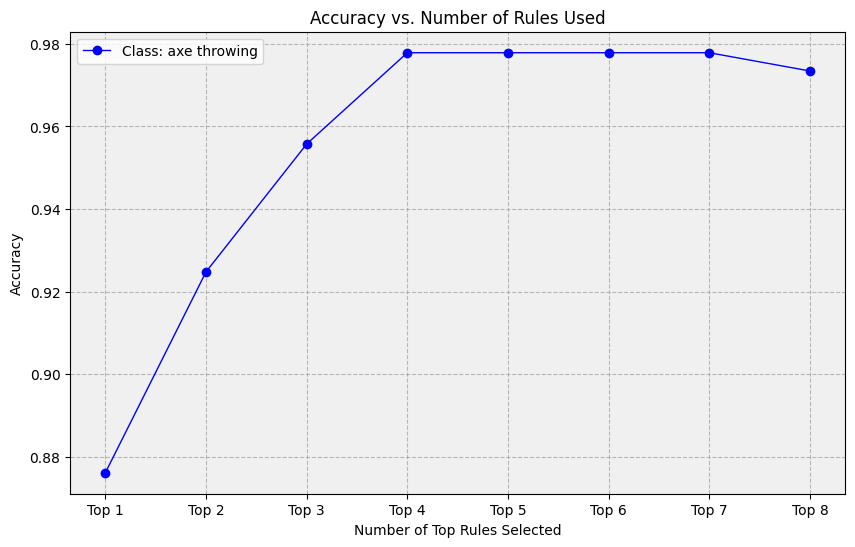

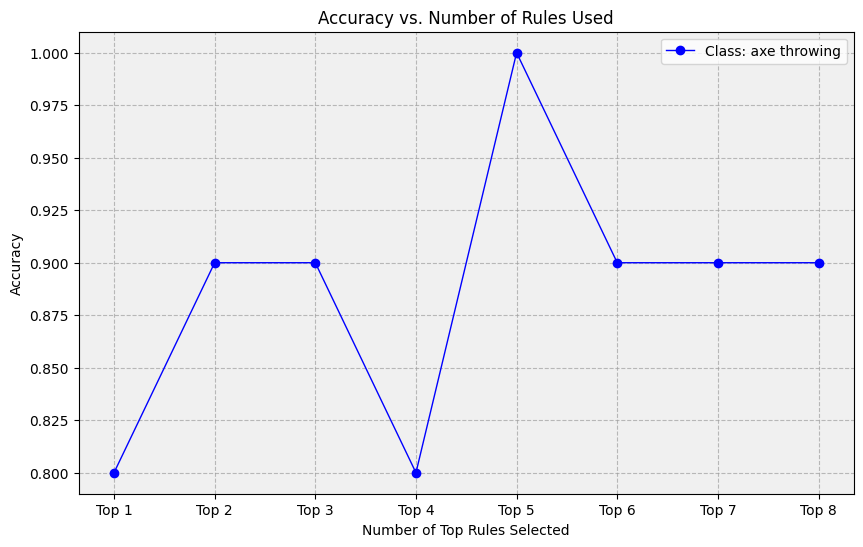

In [125]:
from rules_extraction.plot import plot_accuracy, plot_frontier

plot_accuracy(rules, df_train, class_name='axe throwing', n=9, save_path=None)
plot_accuracy(rules, df_test, class_name='axe throwing', n=9, save_path=None)

/home/arthur.babey/miniconda3/envs/rules2/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



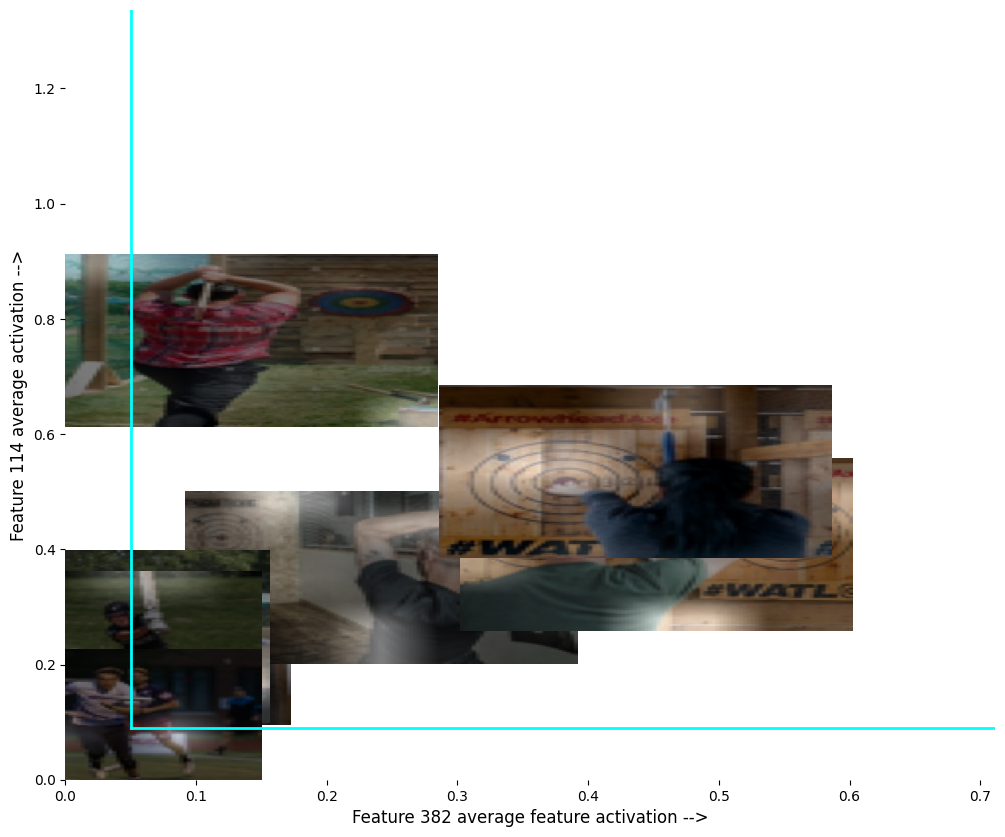

In [111]:
plot_frontier(test_features, rule=rules[0], target_class='axe throwing', model=model, alpha=0.55, device=device)

## Feature Visualisation